In [1]:
from skimage.io import imread
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
import time


In [2]:
rootfolder = '..'

Load the image and rescale it in $[0,1]$

In [3]:
img = imread(f'{rootfolder}/data/cameraman.png') / 255
img = img[50:200, 50:200]
imsz = img.shape

# patch size
p = 7

# number of elements in the patch
M = p ** 2

# radius of the search neighborhood
H = 12

assert p % 2 == 1, 'Patch size must be odd'


Corrupt the image with white gaussian noise

In [4]:
sigma_noise = 20/255
noisy_img = img + sigma_noise * np.random.randn(*img.shape)

Compute the psnr of the noisy input

In [5]:
psnr_noisy = 10 * np.log10(1 / np.mean((noisy_img - img) ** 2))
psnr_noisy

22.128470549613617

Text(0.5, 1.0, 'Noisy image, PSNR = 22.13')

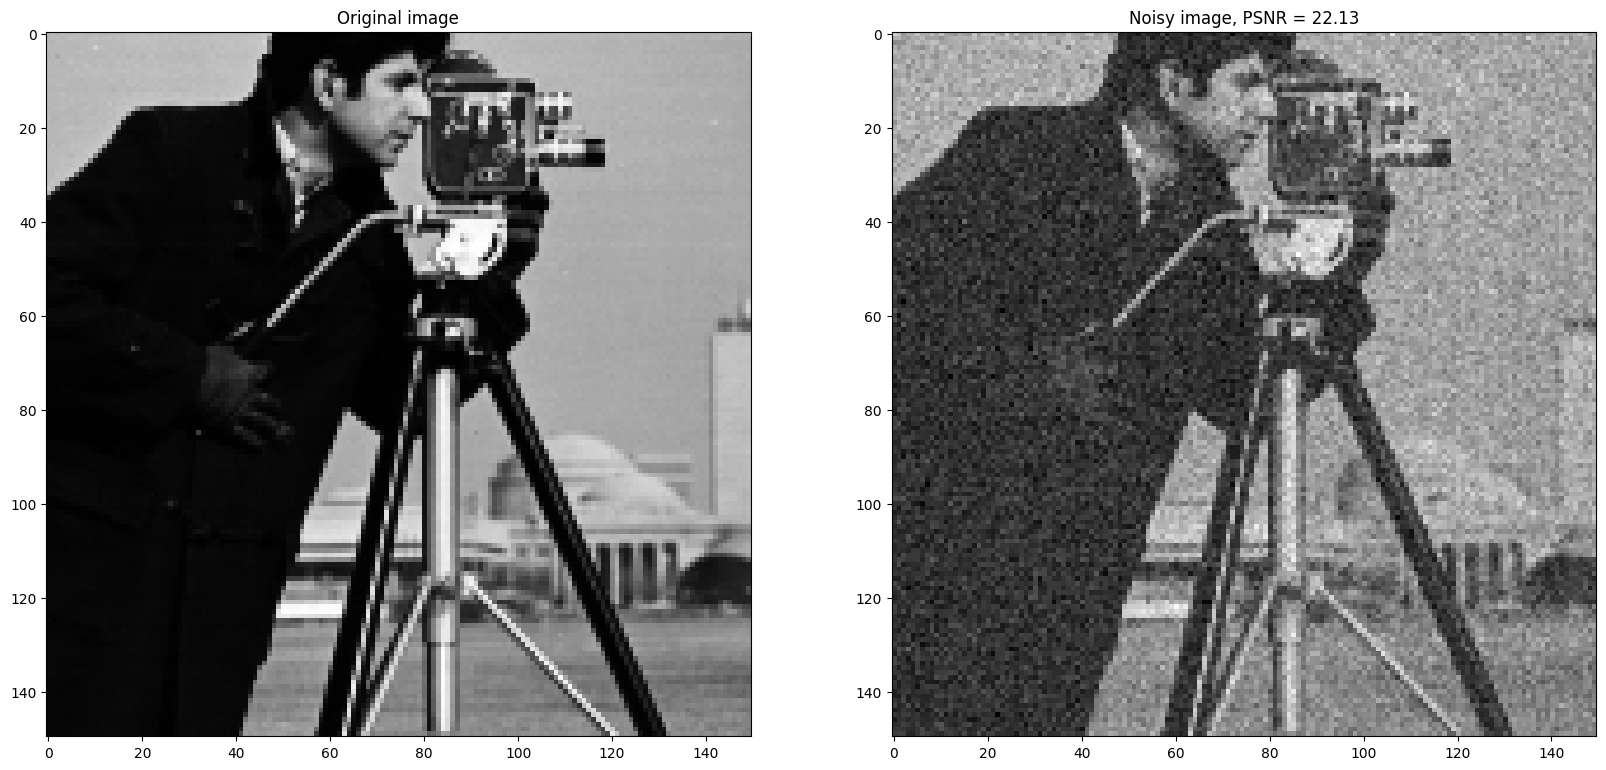

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(noisy_img, cmap='gray')
ax[1].set_title(f'Noisy image, PSNR = {psnr_noisy:.2f}')


Pixel-based NL-Means
--------------------
Set parameters and initialize the variables

In [7]:
# initialize the estimated image
img_hat = np.zeros_like(img)

# pad the noisy image
img_pad = np.pad(noisy_img, p//2, mode='symmetric')
img_pad.shape

(156, 156)

Main loop

In [8]:
for i in range(0, imsz[0]):
    for j in range(0, imsz[1]):
        # extrach the patch from img_pad whose center has the location (i, j) in the noisy image
        s = img_pad[i:i+p, j:j+p]

        # initialize the pixel estimate and the total weights
        pixel_hat = 0
        weight = np.zeros((2*H+1, 2*H+1))
        for r in range(-H,H+1):
          for c in range(-H,H+1):
              # extract the patch centered in (r+h+i,c+h+j) if exists
              if r+i >= 0 and c+j >= 0 and r+i+2*(p//2) <= imsz[0]-1 and c+j+2*(p//2) <= imsz[1]-1:
                z = img_pad[r+i:r+i+p, c+j:c+p+j]
                
                # compute the distance with the reference patch
                d = np.linalg.norm(s - z,2) ** 2

                # update the weight and the pixel estimate
                weight[r+H, c+H] = np.exp(-d / (M * sigma_noise ** 2))
                pixel_hat += img_pad[r+i+(p//2),c+j+(p//2)] * weight[r+H, c+H]

        # estimate the pixel (i, j) as the weighted average of the central pixel of the extracted patches
        img_hat[i, j] = pixel_hat / np.sum(weight)


Compute the psnr of the estimated image

Text(0.5, 1.0, 'Estimated Image,\nPSNR = 27.01')

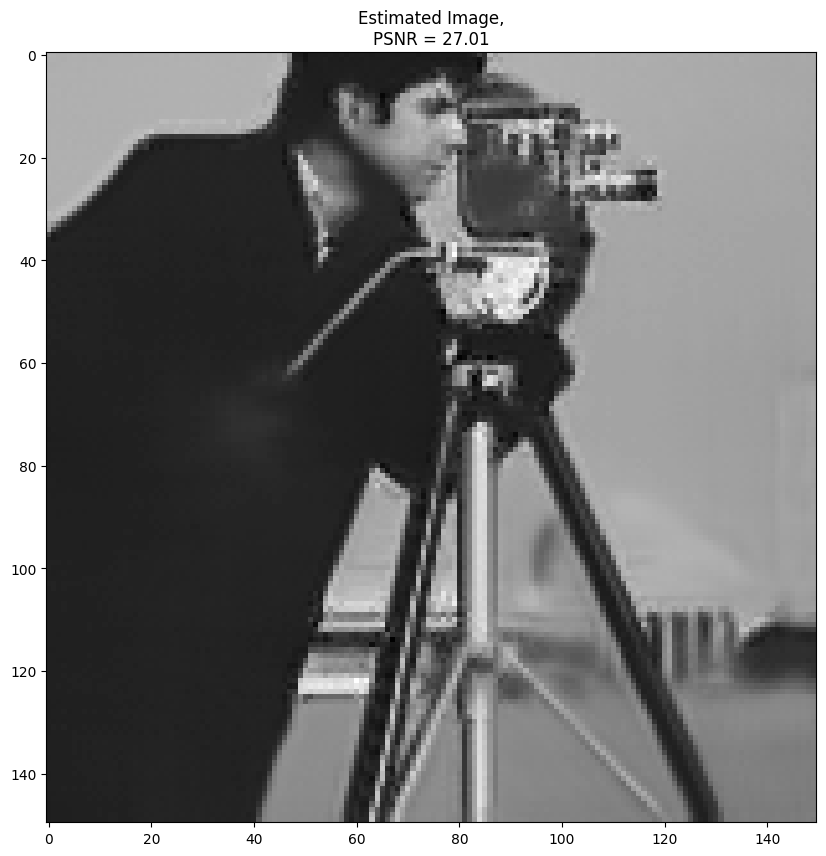

In [9]:
psnr_hat = 10 * np.log10(1 / np.mean((img_hat - img) ** 2))
plt.figure(figsize=(10,10))
plt.imshow(img_hat, cmap='gray')
plt.title(f'Estimated Image,\nPSNR = {psnr_hat:.2f}')
